In [1]:
%matplotlib widget


# Annotation Capture (Versammlungsstöße)

1. YAML-Szene laden.
2. Seite aus Gretillat anzeigen.
3. Alle Referenz- und Ballpunkte nacheinander anklicken (ein Fenster reicht, Zoom bleibt erhalten).
4. Koordinaten prüfen, optional weitere Punkte hinzufügen.
5. Werte speichern und Visualisierung kontrollieren.


In [2]:
from pathlib import Path

import numpy as np
import yaml
from PIL import Image
import matplotlib.pyplot as plt

SCENE_PATH = Path('../data/annotations/gretillat/VS-Lang-02-01.yaml')
PAGE_IMAGE = Path('../data/raw/gretillat/long_gather-185.png')

with SCENE_PATH.open() as fh:
    scene_doc = yaml.safe_load(fh)
scene_doc


{'scene': {'id': 'VS-Lang-02-01',
  'title': 'Versammlungsstoß – Direktpunkt über eine Bande',
  'source': {'work': "Gretillat - L'apprentissage du billard français",
   'section': '2.1 Direct point – Gather shot by one band',
   'page': 185},
  'difficulty': 'easy',
  'description': 'Grundstoß zum Sammeln der Bälle über eine lange Bande.',
  'table': {'type': 'carom_standard',
   'size_units': [40, 80],
   'unit': 'diamonds',
   'origin': 'bottom_left',
   'grid_resolution': 0.5,
   'physical_size_cm': [284, 142],
   'variant': 'match'},
  'balls': {'B1': {'color': 'white', 'position': ['TODO', 'TODO']},
   'B2': {'color': 'yellow', 'position': ['TODO', 'TODO']},
   'B3': {'color': 'red', 'position': ['TODO', 'TODO']}},
  'ghost_ball': {'position': ['TODO', 'TODO'],
   'notes': 'Ghost Ball verbindet B1 mit B2 für 2/3-Volle Trefferlinie.'},
  'ball_contact': {'fraction': 0.66, 'label': '2/3-voll'},
  'cue': {'cue_direction': ['TODO', 'TODO'],
   'attack_height': 'low',
   'effect_stage

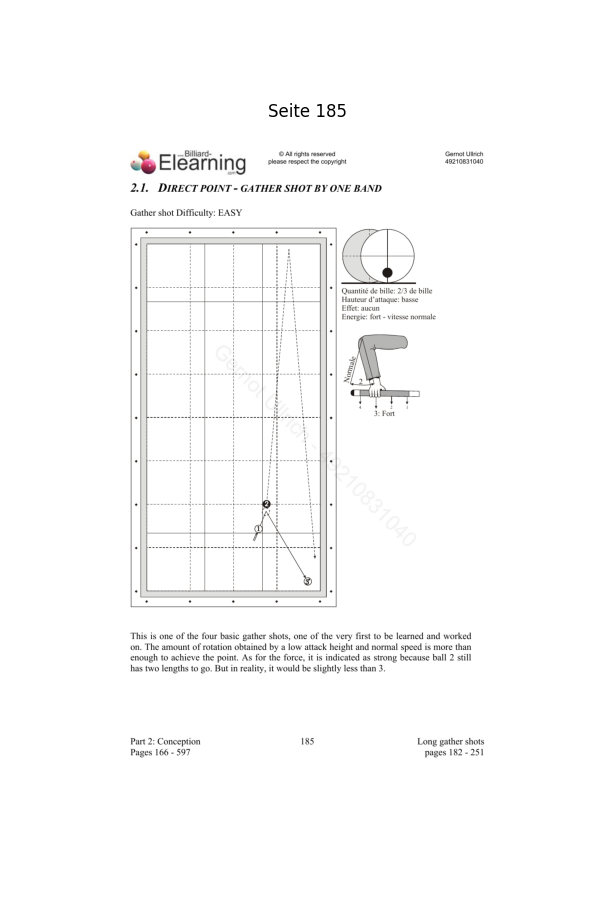

In [3]:
page_img = np.array(Image.open(PAGE_IMAGE))
plt.figure(figsize=(6, 9))
plt.imshow(page_img)
plt.axis('off')
plt.title(f"Seite {scene_doc['scene']['source']['page']}")
plt.show()


In [4]:
try:
    import cv2
    HAS_CV2 = True
except ImportError:
    HAS_CV2 = False


def collect_points(image, prompts):
    fig, ax = plt.subplots(figsize=(6, 9))
    ax.imshow(image)
    ax.set_title(prompts[0])
    plt.show(block=False)
    print("-- Toolbar nutzen (Zoom/Pan). Mit Enter bestätigen, wenn bereit --")
    input("Enter zum Starten…")
    points = []
    for prompt in prompts:
        ax.set_title(prompt)
        plt.draw()
        click = plt.ginput(1, timeout=0)
        if not click:
            raise RuntimeError("Keine Eingabe erhalten")
        x, y = float(click[0][0]), float(click[0][1])
        points.append((x, y))
        print(f"{prompt}: Pixel=({x:.1f}, {y:.1f})")
    plt.close(fig)
    return np.array(points, dtype=float)


def compute_calibration(calib_pixels):
    pixel = np.column_stack((calib_pixels, np.ones(3)))
    table = np.array([[0.0, 0.0], [40.0, 0.0], [0.0, 80.0]])
    Mx, _, _, _ = np.linalg.lstsq(pixel, table[:, 0], rcond=None)
    My, _, _, _ = np.linalg.lstsq(pixel, table[:, 1], rcond=None)
    return np.vstack([Mx, My])


def pixel_to_table(matrix, point):
    x, y = point
    vec = np.array([x, y, 1.0])
    tx = matrix @ vec
    return float(tx[0]), float(tx[1])


def refine_center(image, guess, radius=35):
    x, y = map(int, guess)
    h, w = image.shape[:2]
    x0, x1 = max(x - radius, 0), min(x + radius, w)
    y0, y1 = max(y - radius, 0), min(y + radius, h)
    patch = image[y0:y1, x0:x1]
    if patch.size == 0:
        return guess
    gray = patch.mean(axis=2).astype(np.uint8)
    if HAS_CV2:
        blur = cv2.medianBlur(gray, 5)
        circles = cv2.HoughCircles(
            blur,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=radius * 0.8,
            param1=80,
            param2=15,
            minRadius=int(radius * 0.3),
            maxRadius=int(radius * 1.1),
        )
        if circles is not None:
            cx, cy, _ = circles[0][0]
            return x0 + float(cx), y0 + float(cy)
    thresh = gray.mean()
    mask = gray < thresh
    coords = np.column_stack(np.nonzero(mask))
    if coords.size == 0:
        return guess
    cy, cx = coords.mean(axis=0)
    return x0 + float(cx), y0 + float(cy)


def to_native(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return [to_native(v) for v in obj.tolist()]
    if isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_native(v) for v in obj]
    if isinstance(obj, tuple):
        return [to_native(v) for v in obj]
    return obj


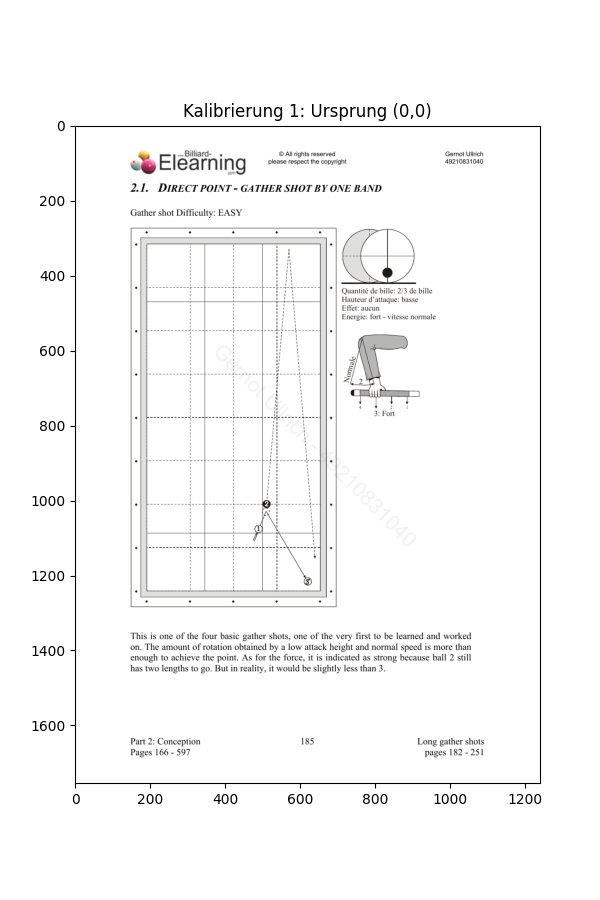

-- Toolbar nutzen (Zoom/Pan). Mit Enter bestätigen, wenn bereit --


Enter zum Starten… 


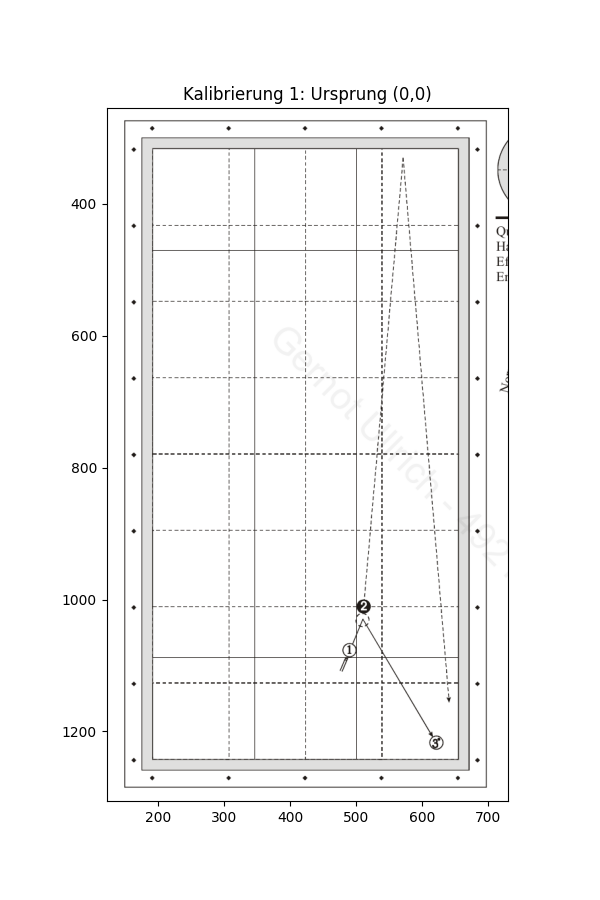

Kalibrierung 1: Ursprung (0,0): Pixel=(190.9, 1238.7)
Kalibrierung 2: lange Bande (40,0): Pixel=(653.1, 1237.1)
Kalibrierung 3: kurze Bande (0,80): Pixel=(190.9, 317.3)
Ball B1: Pixel=(486.4, 1076.5)
Ball B2: Pixel=(506.1, 1009.8)
Ball B3: Pixel=(619.7, 1217.4)
Ghost Ball: Pixel=(507.6, 1029.5)
Pixelpositionen:
B1: (469.6000003814697, 1077.6000022888184)
B2: (511.20000076293945, 1010.6000022888184)
B3: (636.2000007629395, 1224.6000022888184)
Ghost: (511.0, 1011.4000015258789)

Tischkoordinaten:
B1: x=24.12, y=13.90
B2: x=27.72, y=19.71
B3: x=38.54, y=1.09
Ghost: x=27.71, y=19.64


Zusätzliche Punkte (Banden/Trajektorie)? Anzahl eingeben, 0 für keine:  3


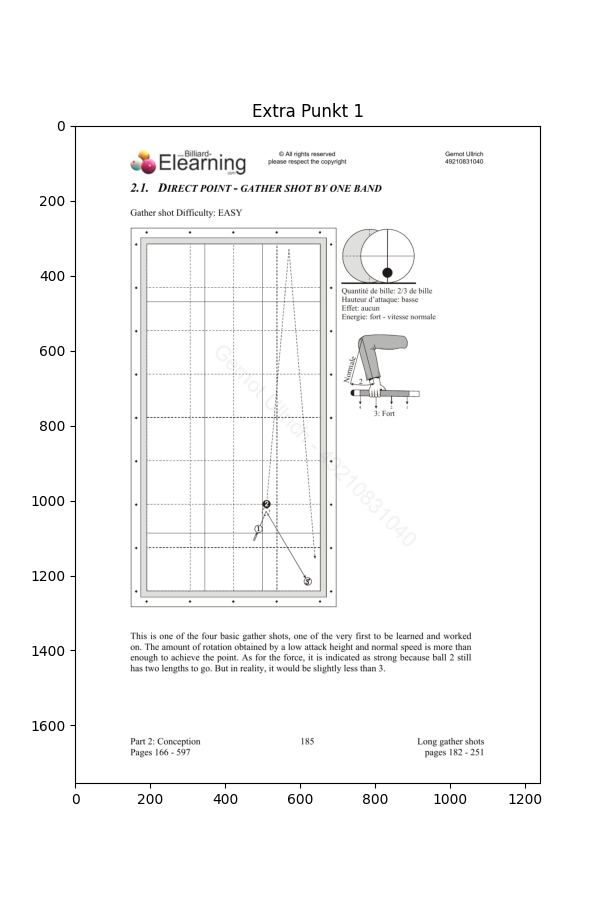

-- Toolbar nutzen (Zoom/Pan). Mit Enter bestätigen, wenn bereit --


Enter zum Starten… 


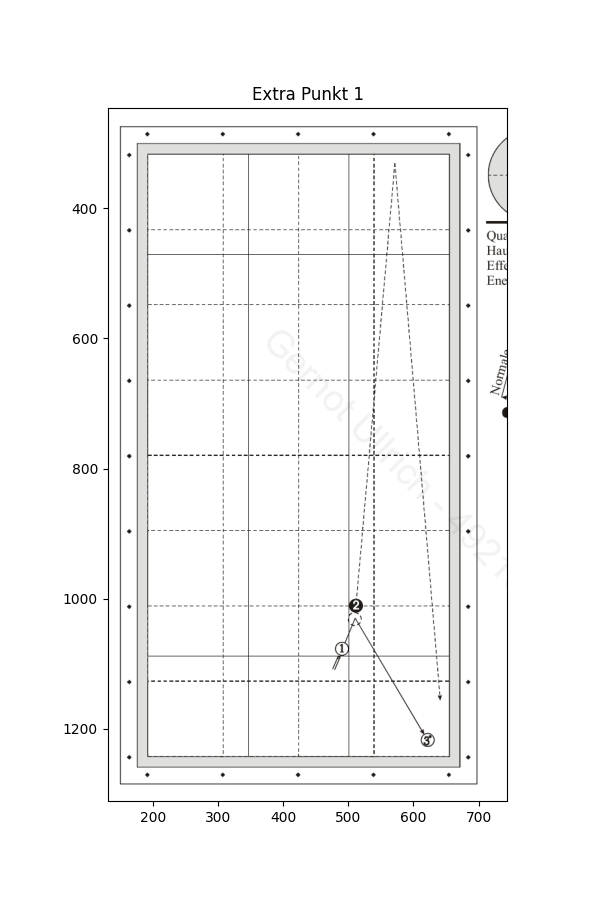

Extra Punkt 1: Pixel=(511.7, 994.1)
Extra Punkt 2: Pixel=(568.6, 330.3)
Extra Punkt 3: Pixel=(639.2, 1149.3)
Extra Punkt 1: Tisch=(27.74, 19.66)
Extra Punkt 2: Tisch=(32.50, 80.30)
Extra Punkt 3: Tisch=(40.52, 7.83)


[{'name': 'Extra Punkt 1', 'pixel': (511.4, 1011.2), 'table': (27.74, 19.66)},
 {'name': 'Extra Punkt 2', 'pixel': (566.5, 312.6), 'table': (32.5, 80.3)},
 {'name': 'Extra Punkt 3', 'pixel': (659.1, 1147.0), 'table': (40.52, 7.83)}]

In [5]:
prompts = [
    "Kalibrierung 1: Ursprung (0,0)",
    "Kalibrierung 2: lange Bande (40,0)",
    "Kalibrierung 3: kurze Bande (0,80)",
    "Ball B1",
    "Ball B2",
    "Ball B3",
    "Ghost Ball"
]
points = collect_points(page_img, prompts)
calib_pixels = points[:3]
ball_pixels = points[3:]
calibration_matrix = compute_calibration(calib_pixels)

names = ['B1', 'B2', 'B3', 'Ghost']
refined_pixels = {}
table_coords = {}
for name, guess in zip(names, ball_pixels):
    refined = refine_center(page_img, guess)
    refined_pixels[name] = refined
    table_coords[name] = pixel_to_table(calibration_matrix, refined)

print("Pixelpositionen:")
for name, coords in refined_pixels.items():
    print(f"{name}: {coords}")

print("\nTischkoordinaten:")
for name, coords in table_coords.items():
    print(f"{name}: x={coords[0]:.2f}, y={coords[1]:.2f}")

extra_points = []
extra_count = int(input("Zusätzliche Punkte (Banden/Trajektorie)? Anzahl eingeben, 0 für keine: "))
if extra_count > 0:
    extra_prompts = [f"Extra Punkt {i+1}" for i in range(extra_count)]
    extra_clicks = collect_points(page_img, extra_prompts)
    for label, click in zip(extra_prompts, extra_clicks):
        refined = refine_center(page_img, click)
        coords = pixel_to_table(calibration_matrix, refined)
        extra_points.append({
            'name': label,
            'pixel': (round(refined[0], 1), round(refined[1], 1)),
            'table': (round(coords[0], 2), round(coords[1], 2)),
        })
        print(f"{label}: Tisch=({coords[0]:.2f}, {coords[1]:.2f})")
extra_points


In [6]:
scene = scene_doc.copy()
scene_ball_data = scene['scene']['balls']
for name in ['B1', 'B2', 'B3']:
    x, y = table_coords[name]
    scene_ball_data[name]['position'] = [round(x, 2), round(y, 2)]
scene['scene']['ghost_ball']['position'] = [
    round(table_coords['Ghost'][0], 2),
    round(table_coords['Ghost'][1], 2),
]

b1 = np.array(scene_ball_data['B1']['position'])
ghost = np.array(scene['scene']['ghost_ball']['position'])
vec = ghost - b1
norm = np.linalg.norm(vec)
if norm > 0:
    scene['scene']['cue']['cue_direction'] = to_native((vec / norm).round(4).tolist())

scene['scene']['trajectory']['B1'][0]['to'] = scene['scene']['ghost_ball']['position']
scene


{'scene': {'id': 'VS-Lang-02-01',
  'title': 'Versammlungsstoß – Direktpunkt über eine Bande',
  'source': {'work': "Gretillat - L'apprentissage du billard français",
   'section': '2.1 Direct point – Gather shot by one band',
   'page': 185},
  'difficulty': 'easy',
  'description': 'Grundstoß zum Sammeln der Bälle über eine lange Bande.',
  'table': {'type': 'carom_standard',
   'size_units': [40, 80],
   'unit': 'diamonds',
   'origin': 'bottom_left',
   'grid_resolution': 0.5,
   'physical_size_cm': [284, 142],
   'variant': 'match'},
  'balls': {'B1': {'color': 'white', 'position': [24.12, 13.9]},
   'B2': {'color': 'yellow', 'position': [27.72, 19.71]},
   'B3': {'color': 'red', 'position': [38.54, 1.09]}},
  'ghost_ball': {'position': [27.71, 19.64],
   'notes': 'Ghost Ball verbindet B1 mit B2 für 2/3-Volle Trefferlinie.'},
  'ball_contact': {'fraction': 0.66, 'label': '2/3-voll'},
  'cue': {'cue_direction': [0.5303, 0.8478],
   'attack_height': 'low',
   'effect_stage': 'stage_

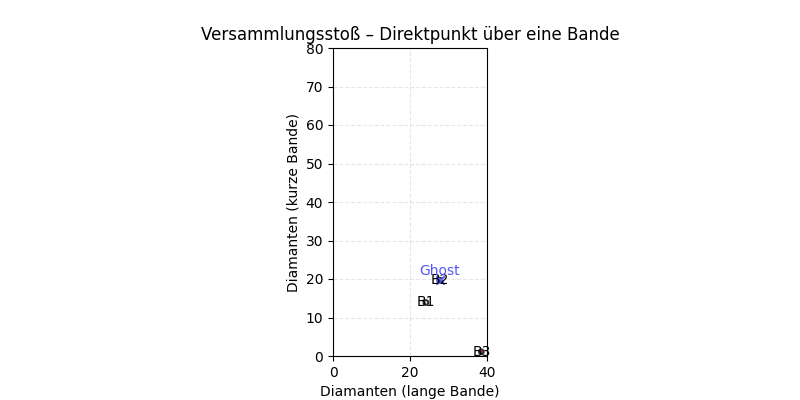

In [7]:
table = scene['scene']['table']
width, height = table['size_units']
balls = scene['scene']['balls']

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect('equal')
ax.set_title(scene['scene']['title'])
ax.set_xlabel('Diamanten (lange Bande)')
ax.set_ylabel('Diamanten (kurze Bande)')
ax.grid(True, linestyle='--', alpha=0.3)

colors = {'white': '#ffffff', 'yellow': '#f8d93b', 'red': '#c0392b'}
ball_radius = 0.61
for name, data in balls.items():
    x, y = data['position']
    circle = plt.Circle((x, y), ball_radius, facecolor=colors.get(data['color'], '#dddddd'), edgecolor='#333333', linewidth=1.5)
    ax.add_patch(circle)
    ax.text(x, y, name, ha='center', va='center', fontsize=10)

ghost_x, ghost_y = scene['scene']['ghost_ball']['position']
ghost_circle = plt.Circle((ghost_x, ghost_y), ball_radius, facecolor='none', edgecolor='#5555ff', linestyle='--')
ax.add_patch(ghost_circle)
ax.scatter([ghost_x], [ghost_y], color='#5555ff', marker='x')
ax.text(ghost_x, ghost_y + ball_radius * 1.2, 'Ghost', ha='center', va='bottom', color='#5555ff')

b2_x, b2_y = balls['B2']['position']
ax.plot([ghost_x, b2_x], [ghost_y, b2_y], color='#5555ff', linestyle=':')

plt.show()


In [8]:
confirm = input("Szene in YAML speichern? (y/n): ").strip().lower()
if confirm == 'y':
    with SCENE_PATH.open('w') as fh:
        yaml.safe_dump(to_native(scene), fh, allow_unicode=True, sort_keys=False)
    print("Gespeichert:", SCENE_PATH)
else:
    print("Nicht gespeichert.")


Szene in YAML speichern? (y/n):  y


Gespeichert: ../data/annotations/gretillat/VS-Lang-02-01.yaml
